# Results

1. Year long comparison of SDR and HDR
2. Comparison of the systems componets contribution to the end-to-end system
    - HDR
    - SDR
5. Anlysis of increased audience (requires 3 runs of the model with different mean growths)
6. Analysis of Stoarge intensity (SDD and HDD) for both SDR and HDR
7. Energy vs Carbon footprint (shows the variation in carbob intesity)





In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import matplotlib.dates as mdates

#Constant variables 
grid_width = 3
fontsize = 34
legend_fontsize = 28

In [174]:
sheet_1 = "mean energy"
sheet_2 = "mean carbon"

#To big of a mean growth in audience
test_file = "./output/long_term_carbon_model/aud_mg_008_str_hdd_1457/summary_0506-1433.xlsx"

#BASE (BASE)(AU1)(STR1), audience mean growth of 0.006 and HHD storage value
BASE_file = "./output/long_term_carbon_model/aud_mg_0006_str_hdd_1538/summary_0506-1529.xlsx"

#AU2, audience mean growth of 0.008 and HHD storage value
AUD2_file = "./output/long_term_carbon_model/aud_mg_0008_str_hdd_1607/summary_0506-1604.xlsx"

#AU3, audience mean growth of 0.01 and HHD storage value
AUD3_file = "./output/long_term_carbon_model/aud_mg_001_str_hdd_1635/summary_0506-1630.xlsx"

#STR2, audience mean growth of 0.006 and SSD storage value
STR2_file = "./output/long_term_carbon_model/aud_mg_0006_str_sdd_1705/summary_0506-1658.xlsx"

#TEST
test_energy_df = pd.read_excel(test_file, sheet_name = sheet_1)
test_carbon_df = pd.read_excel(test_file, sheet_name = sheet_2)

#BASE
BASE_energy_df = pd.read_excel(BASE_file, sheet_name = sheet_1)
BASE_carbon_df = pd.read_excel(BASE_file, sheet_name = sheet_2)

#AUD2
AUD2_energy_df = pd.read_excel(AUD2_file, sheet_name = sheet_1)
AUD2_carbon_df = pd.read_excel(AUD2_file, sheet_name = sheet_2)

#AUD3
AUD3_energy_df = pd.read_excel(AUD3_file, sheet_name = sheet_1)
AUD3_carbon_df = pd.read_excel(AUD3_file, sheet_name = sheet_2)

#STR2
STR2_energy_df = pd.read_excel(STR2_file, sheet_name = sheet_1)
STR2_carbon_df = pd.read_excel(STR2_file, sheet_name = sheet_2)

In [175]:
#Function to extract day number
def get_day(group):
    day = group.split("_")[1]
    return int(day)

def get_hour(group):
    hour = group.split("_")[3]
    return int(hour)

def total(df):
    total = df["Origin Datacentre"] + df["Content Delivery Network"] + df["Core Network"] + df["Access Network"] + df["TV"]
    return total    

def format_dr_df(df):
    df = df.reset_index()

    df = df.drop(columns = ["Scenario","index","group"])

    df = df.rename(columns={"Origin Datacentre":"origin_datacentre","Content Delivery Network":"content_delivery_network","Core Network":"core_network","Access Network":"access_network"})
   
    df['datetime'] = df.apply(lambda row: datetime.datetime(2023, 1, 1) + datetime.timedelta(days=row['day'], hours=row['hour']), axis=1)
    df['datetime'] = pd.to_datetime(df['datetime'])
   
    df = df.set_index('datetime')
    df = df.drop(['day', 'hour'], axis=1)
   
    return df

def format_df(df):
    df["day"] = df["group"].apply(get_day)
    df["hour"] = df["group"].apply(get_hour)
    df["total"] = total(df)
    
    df = df[["Scenario","group","day","hour","Origin Datacentre","Content Delivery Network","Core Network","Access Network","TV","total"]]
    
    split_index = df.loc[df["Scenario"] == "HDR"].index[0]
    
    sdr_df = df[:split_index]  
    hdr_df = df[split_index:]
    
    sdr_df = format_dr_df(sdr_df)
    hdr_df = format_dr_df(hdr_df)

    return sdr_df,hdr_df

#resample function
def resample_daily(df):
    df = df.resample('D').sum()
    return df

def resample_monthy(df):
    df = df.resample('M').sum()
    return df

#Summaries the df to give overall sum of each column
def summarise(df):
    column_sums = df.sum()
    print(str(column_sums))
    total_sum = column_sums['total']
    column_percentages = (column_sums / total_sum) * 100
    print(str(column_percentages))

def plot_year(x,y_list,x_label,y_label,title,plot_names,fontsize,legendfontsize,grid_width):
    fig, ax = plt.subplots(figsize=(70,10))
    for i,y in enumerate(y_list):
        ax.plot(x, y,label = plot_names[i])
        ax.fill_between(x, 0, y, alpha=1)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    ax.set_xlabel(x_label,fontsize=fontsize)
    ax.set_ylabel(y_label,fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
    
    ax.grid(True,linewidth=grid_width)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(bottom=0)
    
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.legend(fontsize=legendfontsize)
    
    plt.show()
    fig.clf()
    
def plot_system_components(df,show_TV, title, xlabel, ylabel,fontsize,legendfontsize,grid_width):
    if show_TV:
        component_cols = [col for col in df.columns if col not in ['datetime', 'total']]
    else:
        component_cols = [col for col in df.columns if col not in ['datetime', 'total','TV']]
    
    fig, ax = plt.subplots(figsize=(70,10))
    df[component_cols].plot.area(alpha=0.7, zorder=2, ax=ax)

    ax.set_xlabel(xlabel,fontsize=fontsize)
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)

    df['total'].plot(ax=ax, color='black', linewidth=2, zorder=1)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    ax.grid(True, linestyle='--', alpha=0.5,linewidth=grid_width)
    ax.set_ylim(bottom=0)
    ax.legend(fontsize=legendfontsize)

    plt.show()

#comparison of viewing times

#compariosn of HDD and SDD


In [176]:
#TEST
test_sdr, test_hdr = format_df(test_carbon_df)

#BASE
BASE_sdr, BASE_hdr = format_df(BASE_carbon_df)

#AUD2
AUD2_sdr, AUD2_hdr = format_df(AUD2_carbon_df)

#AUD3
AUD3_sdr, AUD3_hdr = format_df(AUD3_carbon_df)

#STR2
STR2_sdr, STR2_hdr = format_df(STR2_carbon_df)
BASE_sdr

origin_datacentre  content_delivery_network  \
datetime                                                           
2023-01-01 00:00:00           0.681158                  2.907956   
2023-01-01 01:00:00           0.349264                  1.492806   
2023-01-01 02:00:00           0.210452                  0.898624   
2023-01-01 03:00:00           0.131961                  0.563053   
2023-01-01 04:00:00           0.110965                  0.473673   
...                                ...                       ...   
2023-12-31 19:00:00           3.945145                 16.815899   
2023-12-31 20:00:00           3.096474                 13.204809   
2023-12-31 21:00:00           2.882939                 12.299295   
2023-12-31 22:00:00           2.630923                 11.229468   
2023-12-31 23:00:00           1.529925                  6.534448   

                     core_network  access_network            TV         total  
datetime                                                                       
2023-01-01 00:00:00      3.393259        3.708253   3457.042976   3467.733602  
2023-01-01 01:00:00      1.748543        1.907740   1781.699653   1787.198005  
2023-01-01 02:00:00      1.049413        1.146889   1067.417555   1070.722934  
2023-01-01 03:00:00      0.658733        0.719994    670.361062    672.434803  
2023-01-01 04:00:00      0.553768        0.604632    564.637926    566.380964  
...                           ...             ...           ...           ...  
2023-12-31 19:00:00     19.691278       21.502337  20068.026508  20129.981168  
2023-12-31 20:00:00     15.435412       16.804139  15677.078935  15725.619770  
2023-12-31 21:00:00     14.362334       15.698436  14619.092535  14664.335540  
2023-12-31 22:00:00     13.149654       14.334583  13369.341995  13410.686623  
2023-12-31 23:00:00      7.649011        8.344727   7782.051664   7806.109775  

[8760 rows x 6 columns]

# Overall stats

In [177]:
print("TEST---------------------------------------------------------------------------------------\n") 
summarise(BASE_sdr)

print("BASE---------------------------------------------------------------------------------------\n") 
summarise(BASE_sdr)

print("AUD2---------------------------------------------------------------------------------------\n") 
summarise(AUD2_sdr)

print("AUD3---------------------------------------------------------------------------------------\n") 
summarise(AUD3_sdr)

print("STR2---------------------------------------------------------------------------------------\n") 
summarise(STR2_sdr)

TEST---------------------------------------------------------------------------------------

origin_datacentre           2.266193e+04
content_delivery_network    9.670531e+04
core_network                1.131387e+05
access_network              1.234962e+05
TV                          1.151625e+08
total                       1.155185e+08
dtype: float64
origin_datacentre             0.019618
content_delivery_network      0.083714
core_network                  0.097940
access_network                0.106906
TV                           99.691822
total                       100.000000
dtype: float64
BASE---------------------------------------------------------------------------------------

origin_datacentre           2.266193e+04
content_delivery_network    9.670531e+04
core_network                1.131387e+05
access_network              1.234962e+05
TV                          1.151625e+08
total                       1.155185e+08
dtype: float64
origin_datacentre             0.019618
cont

# HDR VS SDR Year comparison

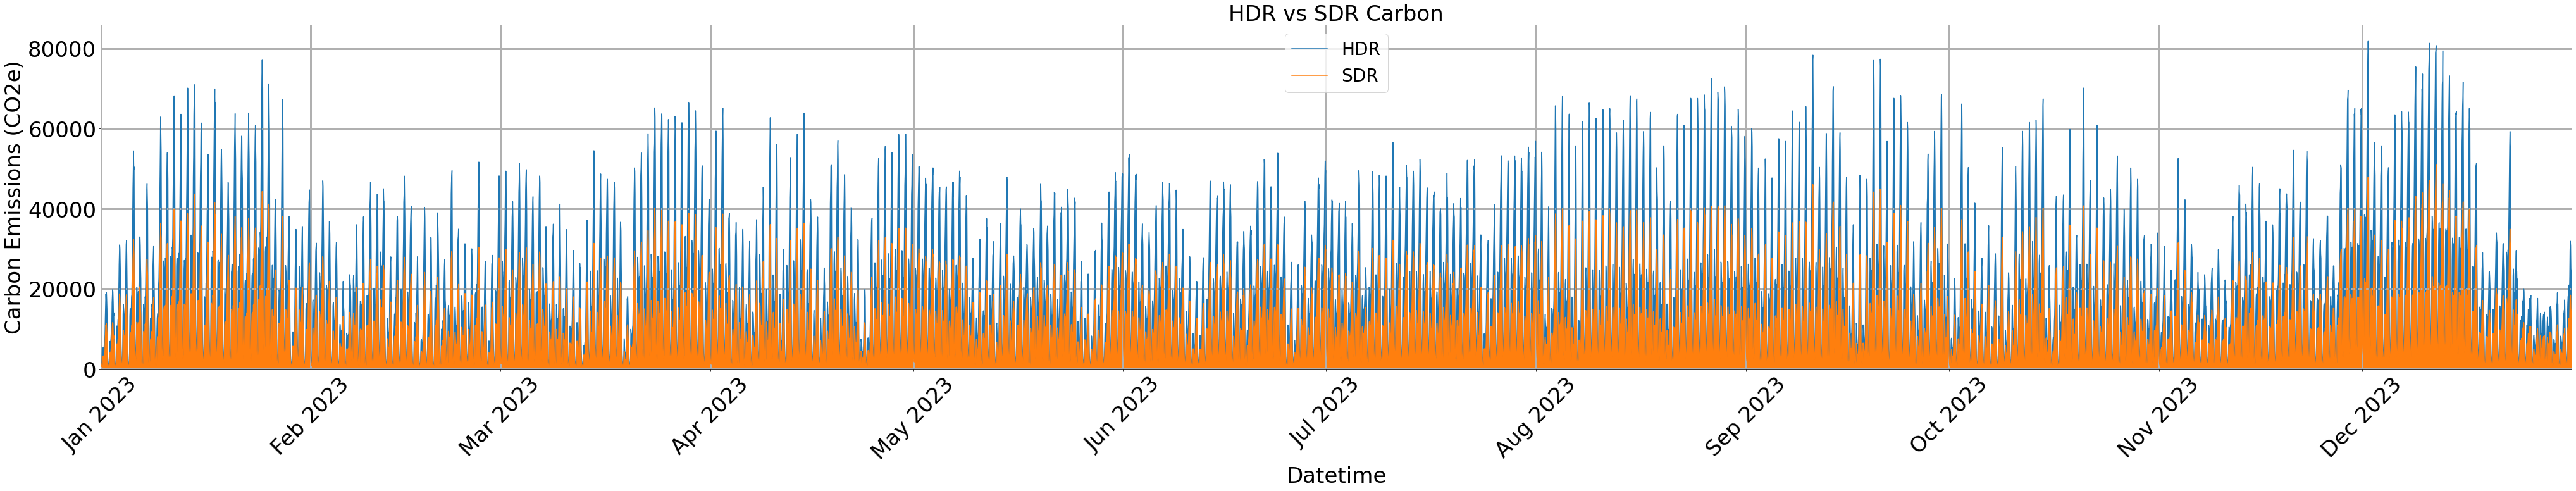

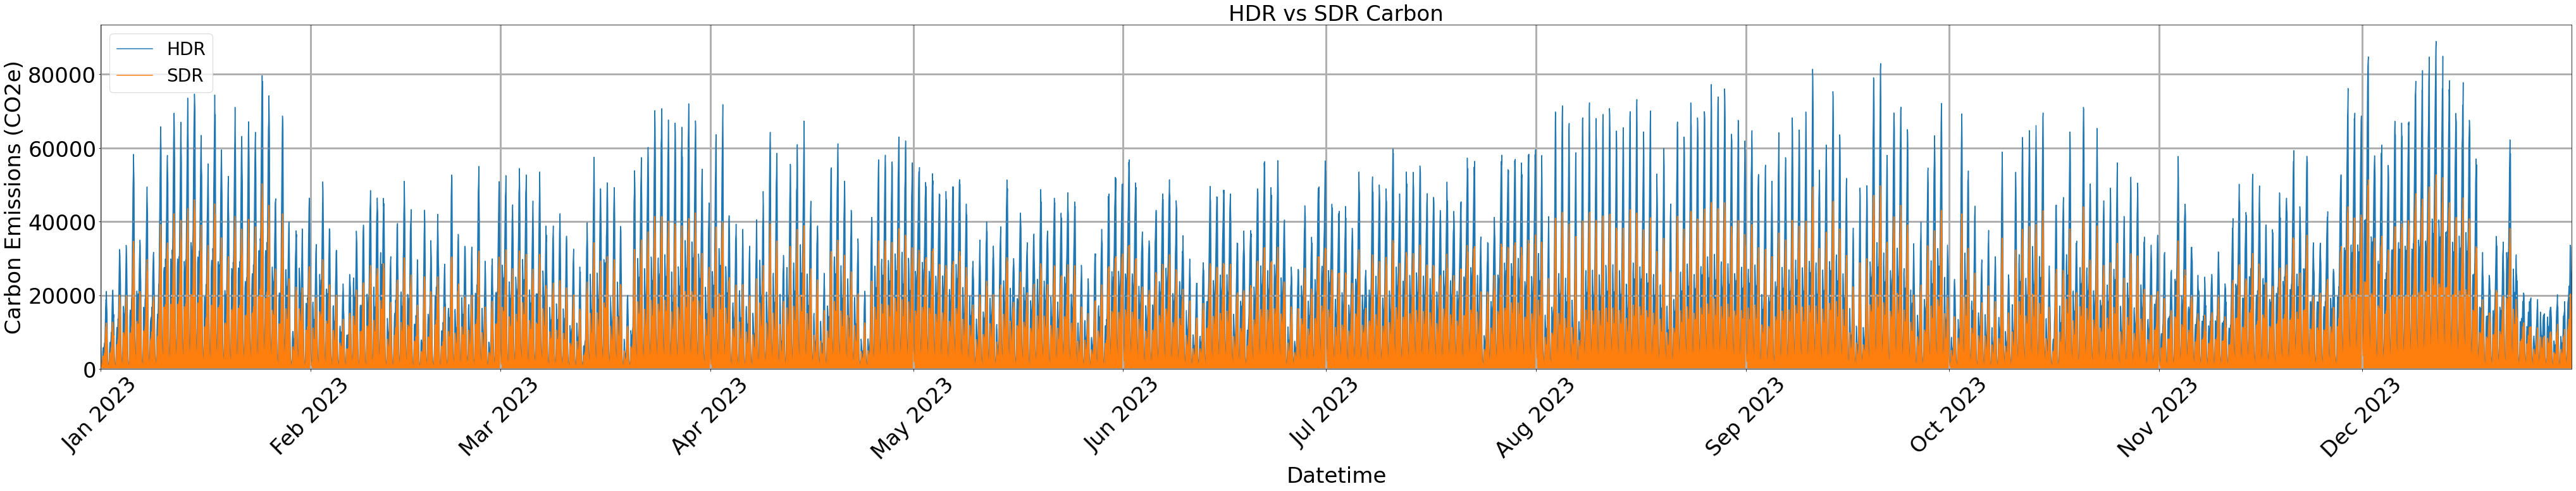

In [178]:
plot_year(test_sdr.index,[test_hdr["total"],test_sdr["total"]], "Datetime", "Carbon Emissions (CO2e)","HDR vs SDR Carbon",["HDR","SDR"],fontsize,legend_fontsize,grid_width)

plot_year(BASE_sdr.index,[BASE_hdr["total"],BASE_sdr["total"]], "Datetime", "Carbon Emissions (CO2e)","HDR vs SDR Carbon",["HDR","SDR"],fontsize,legend_fontsize,grid_width)

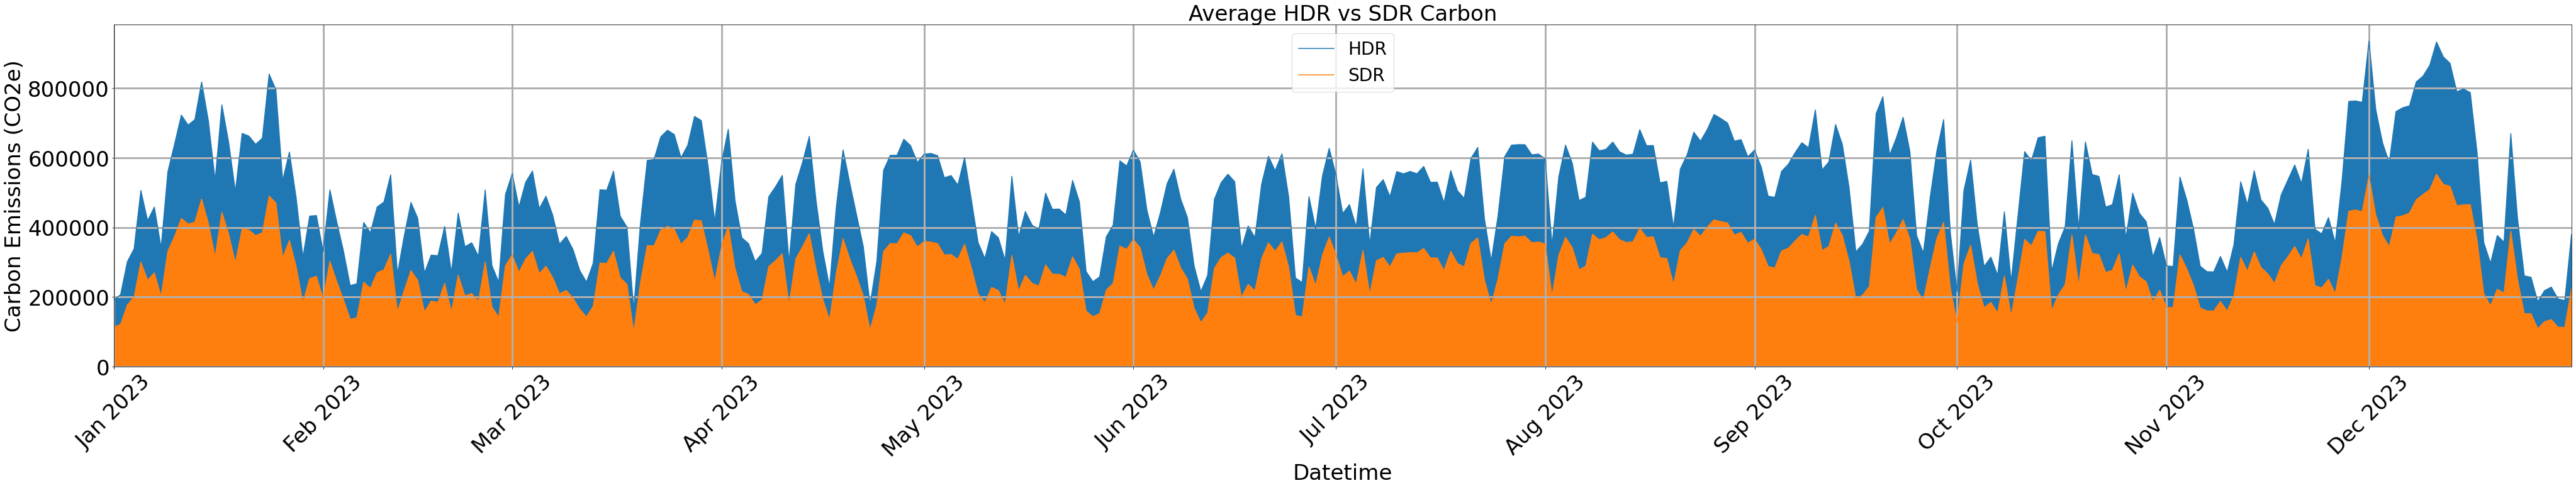

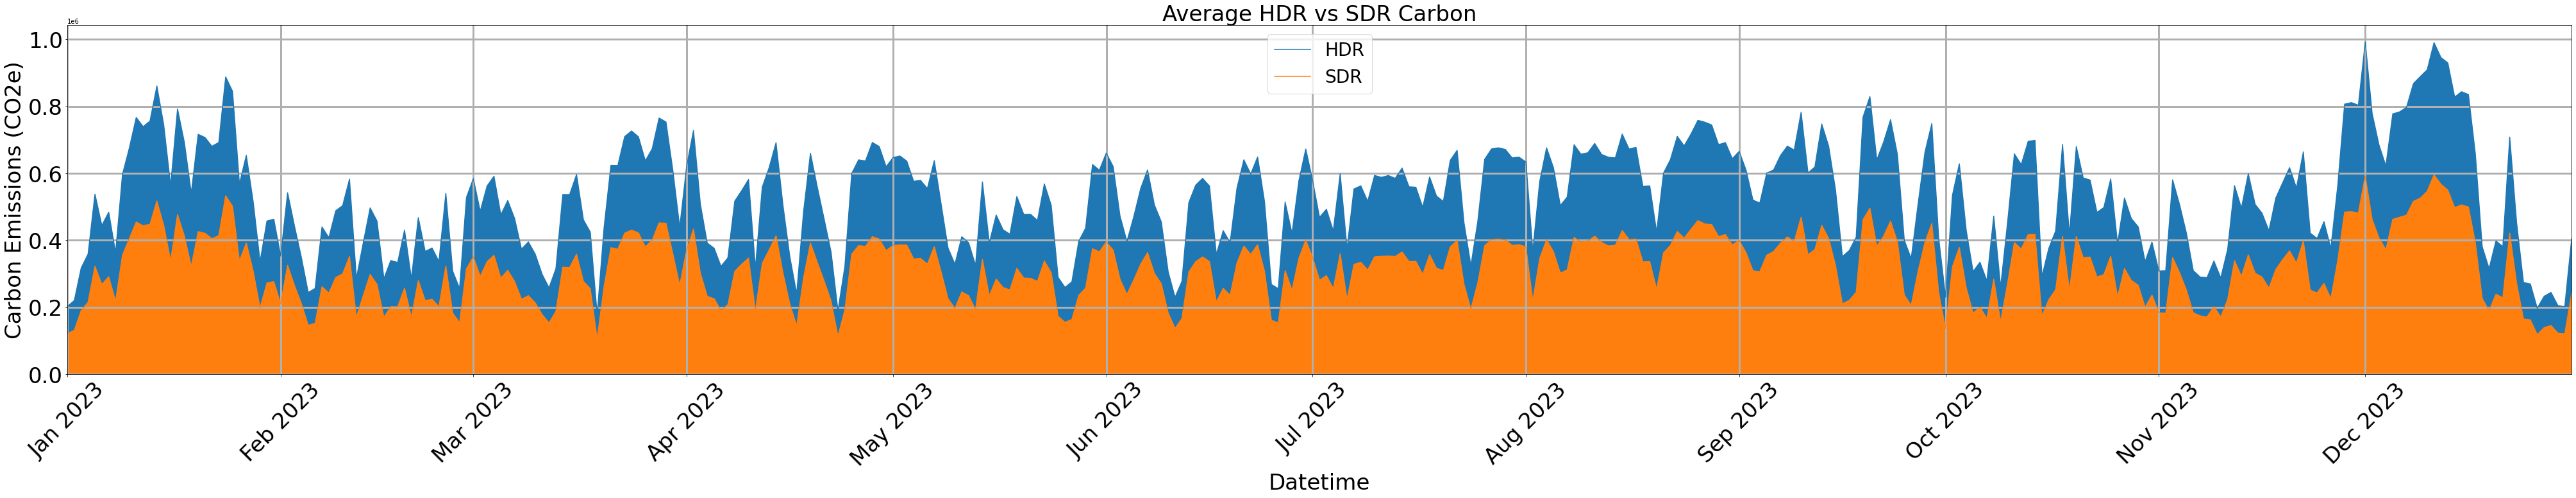

In [179]:
test_sdr_daily = resample_daily(test_sdr)
test_hdr_daily = resample_daily(test_hdr)
plot_year(test_sdr_daily.index,[test_hdr_daily["total"],test_sdr_daily["total"]], "Datetime", "Carbon Emissions (CO2e)","Average HDR vs SDR Carbon",["HDR","SDR"],fontsize,legend_fontsize,grid_width)

BASE_sdr_daily = resample_daily(BASE_sdr)
BASE_hdr_daily = resample_daily(BASE_hdr)
plot_year(BASE_sdr_daily.index,[BASE_hdr_daily["total"],BASE_sdr_daily["total"]], "Datetime", "Carbon Emissions (CO2e)","Average HDR vs SDR Carbon",["HDR","SDR"],fontsize,legend_fontsize,grid_width)

## Year different figure

In [180]:
temp = summarise(BASE_sdr)

STR2 = summarise(STR2_sdr)

origin_datacentre           2.266193e+04
content_delivery_network    9.670531e+04
core_network                1.131387e+05
access_network              1.234962e+05
TV                          1.151625e+08
total                       1.155185e+08
dtype: float64
origin_datacentre             0.019618
content_delivery_network      0.083714
core_network                  0.097940
access_network                0.106906
TV                           99.691822
total                       100.000000
dtype: float64
origin_datacentre           2.327187e+04
content_delivery_network    9.771610e+04
core_network                1.143523e+05
access_network              1.219321e+05
TV                          1.158662e+08
total                       1.162235e+08
dtype: float64
origin_datacentre             0.020023
content_delivery_network      0.084076
core_network                  0.098390
access_network                0.104912
TV                           99.692599
total                       100.00

# Plot comparing System Components

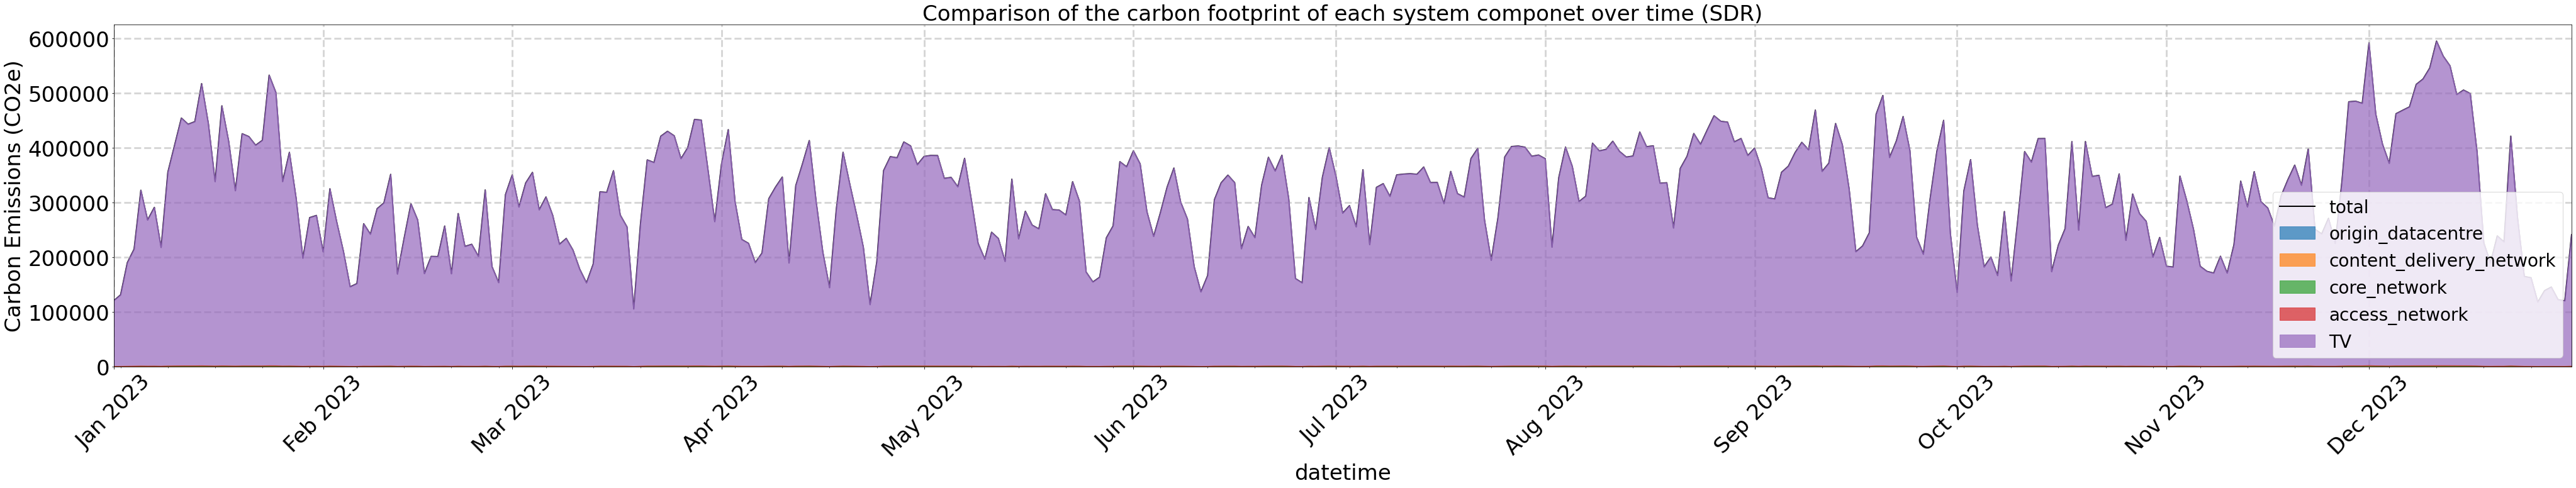

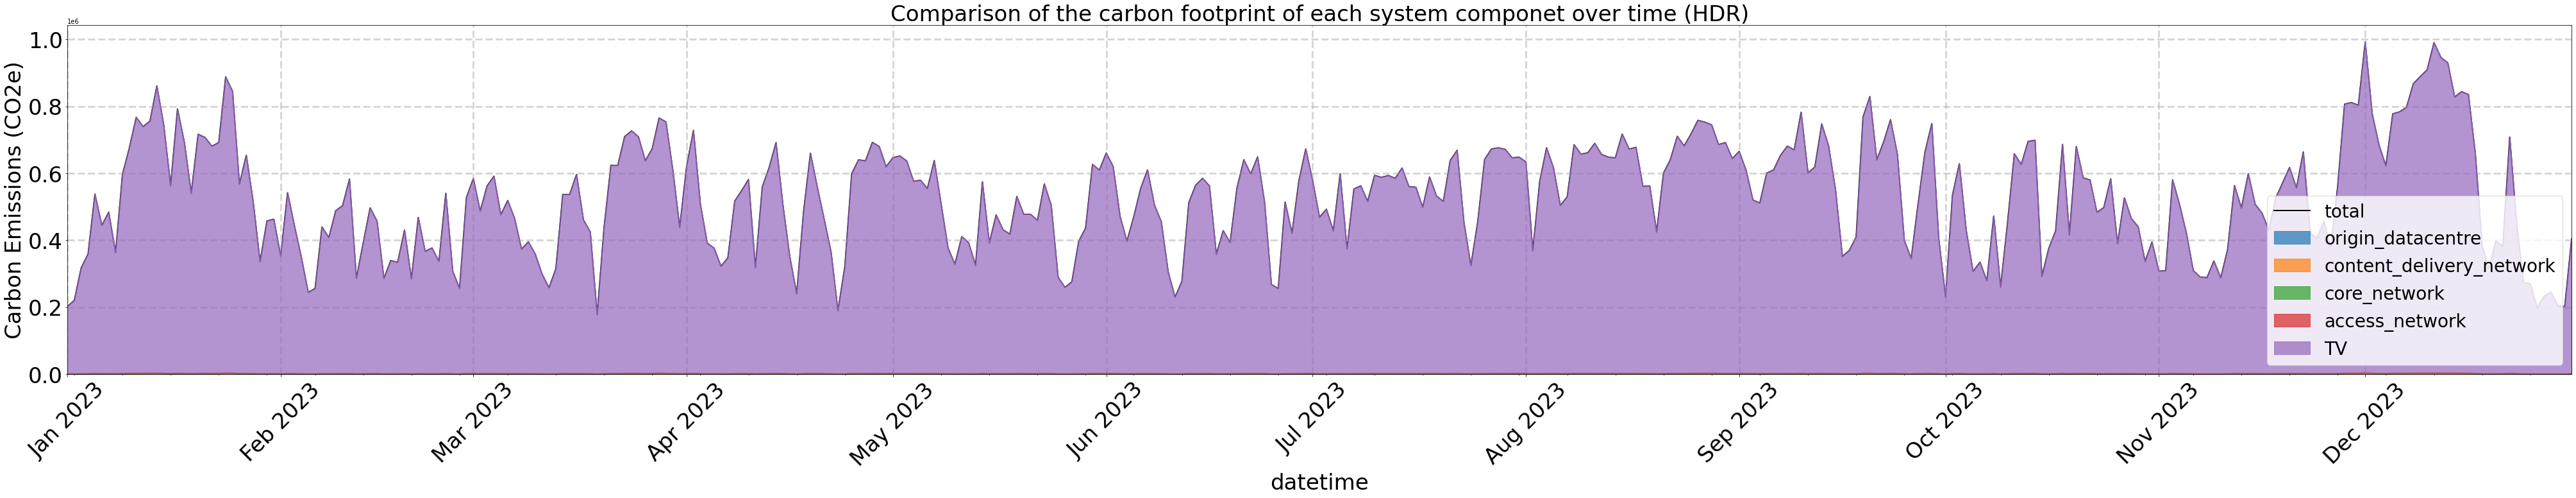

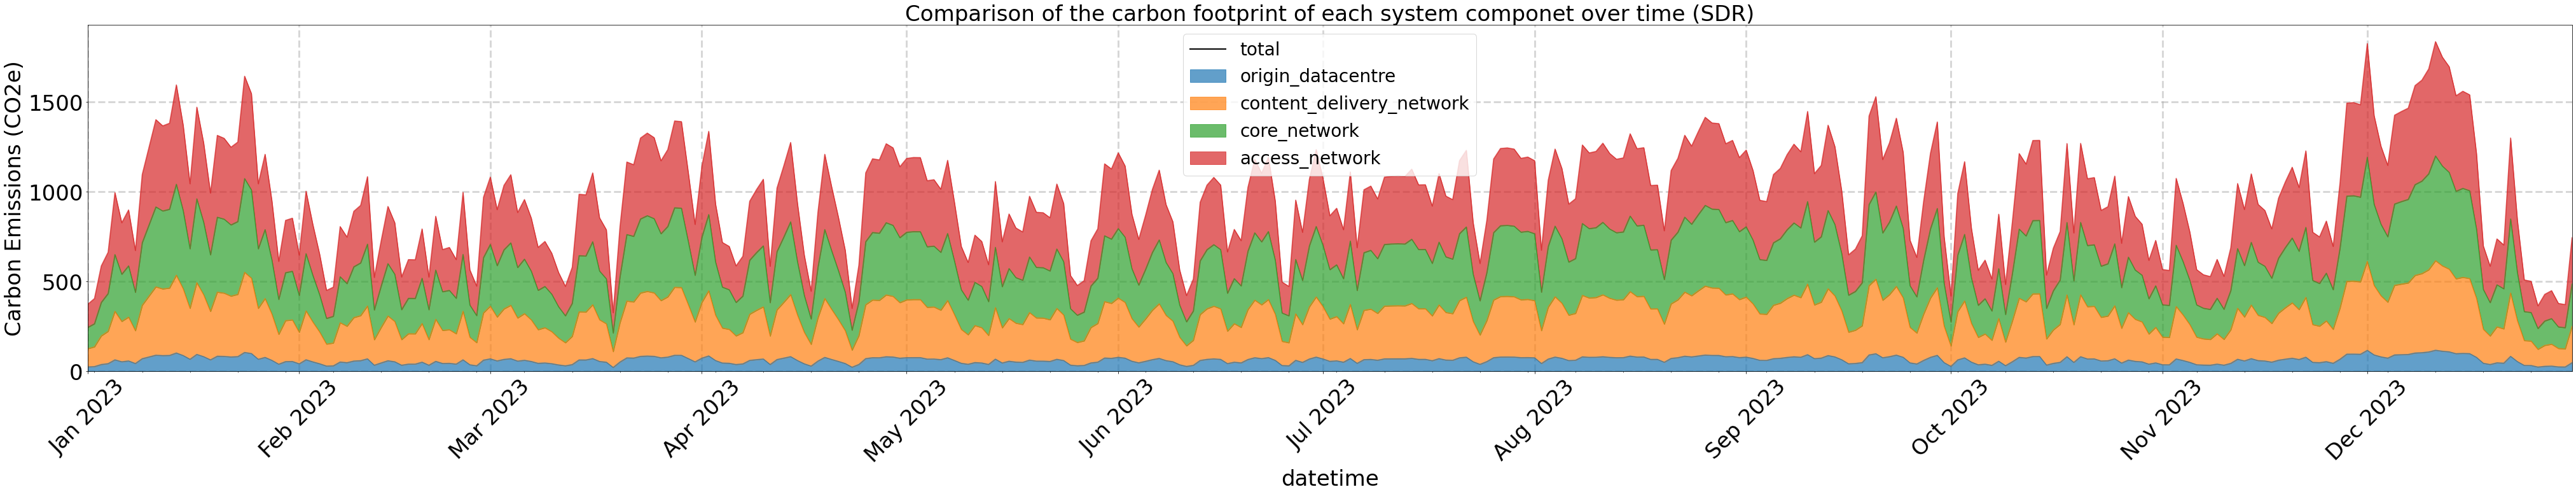

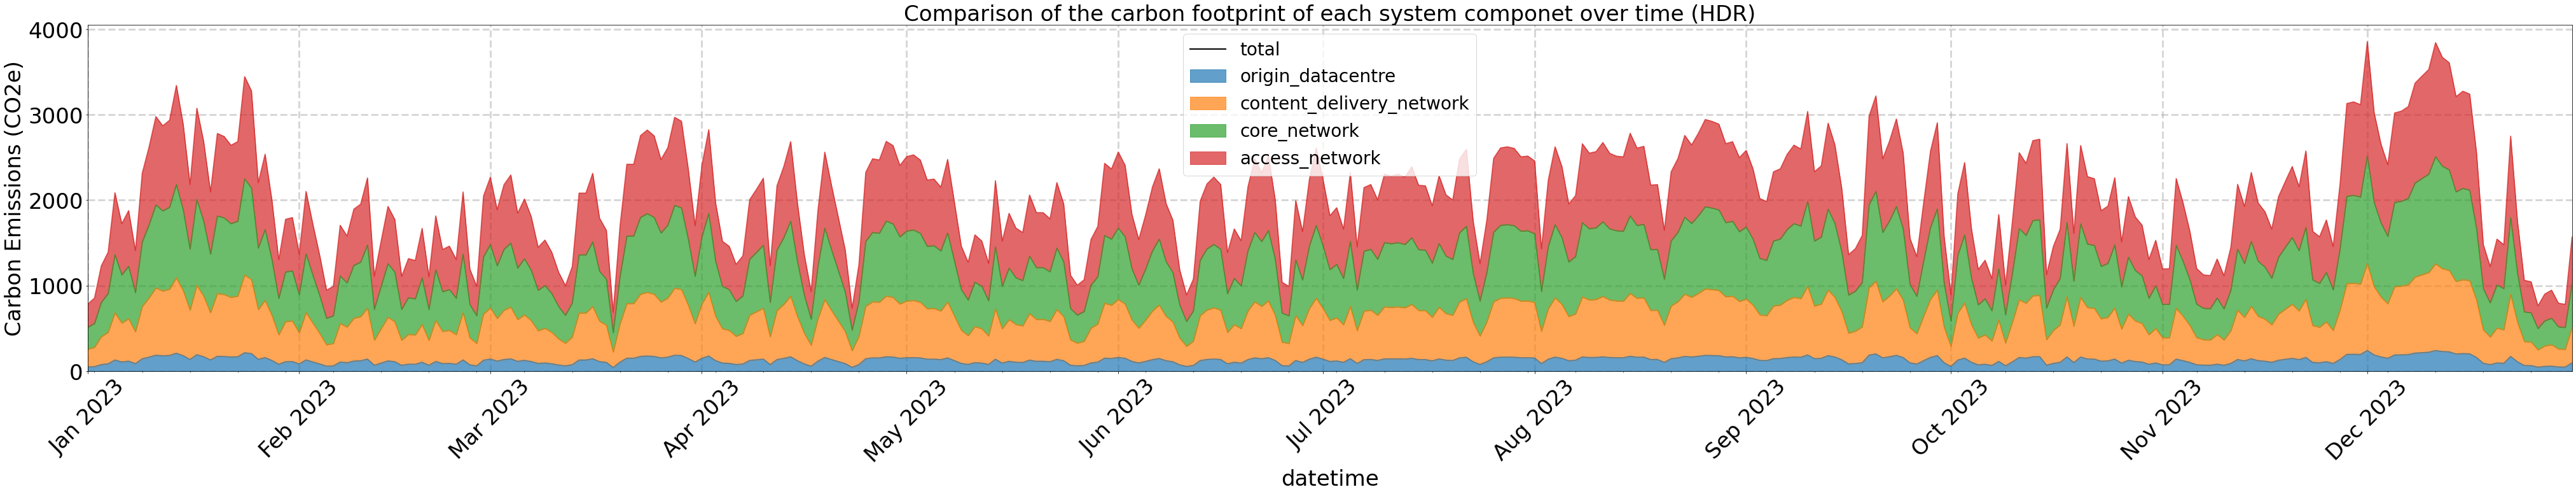

In [181]:
plot_system_components(BASE_sdr_daily,True, "Comparison of the carbon footprint of each system componet over time (SDR)", "datetime", "Carbon Emissions (CO2e)",fontsize,legend_fontsize,grid_width)
plot_system_components(BASE_hdr_daily,True, "Comparison of the carbon footprint of each system componet over time (HDR)", "datetime", "Carbon Emissions (CO2e)",fontsize,legend_fontsize,grid_width)

plot_system_components(BASE_sdr_daily,False, "Comparison of the carbon footprint of each system componet over time (SDR)", "datetime", "Carbon Emissions (CO2e)",fontsize,legend_fontsize,grid_width)
plot_system_components(BASE_hdr_daily,False, "Comparison of the carbon footprint of each system componet over time (HDR)", "datetime", "Carbon Emissions (CO2e)",fontsize,legend_fontsize,grid_width)

# Comparison